In [1]:
from datetime import datetime, date, timedelta
from dateutil.parser import parse
import math
import os
import sys
import time

import pandas as pd
import numpy as np
import geopandas as gpd

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
from matplotlib.backends.backend_pdf import PdfPages

import mapclassify as mc

from pathlib import Path
import requests,json

In [2]:
def read_json_ESRI():
    #
    # Connect to RKI ESRI data service to get the Landkreis geodata
    # and the population data of the Landkreise
    # 
    # Input : None
    # Output: result: GeoDataFrame of the RKI Landkreise
    #
    url="https://services7.arcgis.com/mOBPykOjAyBO2ZKk/arcgis/rest/services/RKI_Landkreisdaten/FeatureServer/0/query?"

    parameter = {
        'referer':'https://www.mywebapp.com',
        'user-agent':'python-requests/2.9.1',
        'where': '1=1', # Welche landkreise sollen zurück gegeben werden
        'outFields': 'RS,GEN,county,EWZ,BL_ID,BL,EWZ_BL', # Rückgabe aller Felder
        'returnGeometry': True, # Mit Geometrien
        'f':'geojson', # Rückgabeformat, hier JSON
        'cacheHint': True # Zugriff über CDN anfragen
    }
    
    result = requests.get(url=url, params=parameter) #Anfrage absetzen
    resultjson = json.loads(result.text) # Das Ergebnis JSON als Python Dictionary laden
    result=gpd.GeoDataFrame.from_features(resultjson)
    result.set_crs(epsg=4326, inplace=True)
    return result



def read_json_BL():
    #
    # Connect to RKI ESRI data service to get the Bundeslaender geodata
    # 
    # Input : None
    # Output: result: GeoDataFrame of the RKI Bundeslaender
    #
    
    url="https://services7.arcgis.com/mOBPykOjAyBO2ZKk/arcgis/rest/services/Coronaf%C3%A4lle_in_den_Bundesl%C3%A4ndern/FeatureServer/0/query?"
    
    parameter = {
        'referer':'https://www.mywebapp.com',
        'user-agent':'python-requests/2.9.1',
        'where': '1=1', # Welche landkreise sollen zurück gegeben werden
        'outFields': 'LAN_ew_GEN,LAN_ew_BEZ', # Rückgabe aller Felder
        'returnGeometry': True, # Mit Geometrien
        'f':'geojson', # Rückgabeformat, hier JSON
        'cacheHint': True # Zugriff über CDN anfragen
    }
    result = requests.get(url=url, params=parameter) #Anfrage absetzen
    resultjson = json.loads(result.text) # Das Ergebnis JSON als Python Dictionary laden
    result=gpd.GeoDataFrame.from_features(resultjson)
    result.set_crs(epsg=4326, inplace=True)
    return result



def get_covid_data_from_RKI(outfile):
    #
    # Connect to RKI data service to download the latest covid database (full version)
    # 
    # Input : outfile, name of csv-file which has the complete covid data 
    # Output: filesize of the csv-file
    #
    covid_url = \
'https://www.arcgis.com/sharing/rest/content/items/f10774f1c63e40168479a1feb6c7ca74/data' 
    r = requests.get(covid_url, allow_redirects=True)
    filesize = open(outfile, 'wb').write(r.content)
    return(filesize)



def read_covid_database(covid_file):
    #
    # Wrapper function for downloading and reading the covid database
    # 
    # Input : covid-file, name of csv-file which has the complete covid data 
    # Output: covid, the complete covid dataframe
    #
    # Remark: Since downloading takes some time, it ist tested if an actual 
    # version of the csv-file already exists on disc
    #
    covid_path=Path(covid_file)
    if not covid_path.is_file():
        get_covid_data_from_RKI(covid_file)
    else:
        print('Using already existing file ', covid_file)
    covid = pd.read_csv(covid_file, parse_dates=['Meldedatum'])
    return(covid)



def get_bundeslad_geodata(bula_file):
    #
    # Read Bundesland geodaten
    #
    # Input: bula_file, Datenfile
    # Output: bland, GeoDataFrame of Bundeslaender
    #
    bula_path=Path(bula_file)
    if not bula_path.is_file():
        bland = read_json_BL()
        bland.to_file(bula_file)
    else:
        bland = gpd.read_file(bula_file)
    return bland



def get_kreise_geodata(kreise_file):
    #
    # Read Landkreis geodaten
    #
    # Input: kreise_file, Datenfile
    # Output: kreise, GeoDataFrame of Landkreise
    #
    kreise_path=Path(kreise_file)
    if not kreise_path.is_file():
        kreise = read_json_ESRI()
        kreise.to_file(kreise_file)
    else:
        kreise = gpd.read_file(kreise_file)
    return(kreise)



def extract_einwohnerzahlen(kreise):
    #
    # Returns table of populations from Landkreise, 
    # Bundesländer und Germany
    # 
    # Input : kreise, ESRI Landkreis Geodataframe
    # Output: einwohner, Datafram with all the population 
    # data (Landkreise, bundeslaendern, germany) 
    
    ewz=pd.DataFrame(kreise)

    bl=ewz.groupby('BL').EWZ_BL.max()
    lk=ewz.groupby('county').EWZ.max()

    summe_ew_deutschland = bl.sum()
    
    einwohner=pd.concat([lk,bl])
    einwohner.loc['Deutschland']=summe_ew_deutschland

    return(einwohner)



def get_tagesinzidenzen(covid, start_date, end_date):
    # 
    # This s one of the main routines:
    # Generate a datelist for every day of the pandemic and 
    # use this list as an index to create an empty dataframe
    #
    # Input: covid, Covid dataframe from RKI
    # Input: start, end: Starting and end-date for the resulting dataframe
    # Output: result, the complete Inzidenz table for all Kreise,
    #         Bundeslaender and Germany for every day from start to end
    #
    tagesliste = pd.date_range(start_date,end_date)
    result=pd.DataFrame(index=tagesliste)
    
    # Main grouping steps for Landkreise, Bundesländer und Deutschland gesamt
    Faelle_lk = covid.groupby(['Landkreis', 'Meldedatum']).AnzahlFall.sum()
    Faelle_bl = covid.groupby(['Bundesland', 'Meldedatum']).AnzahlFall.sum()
    Faelle_d  = covid.groupby('Meldedatum').AnzahlFall.sum()

    lk_auswahl=landkreise
    for i in lk_auswahl:
        tmp=Faelle_lk[i]
        result = pd.concat([result, tmp.rename(i)], axis=1)

    bl_auswahl=bundeslaender
    for i in bl_auswahl:
        tmp=Faelle_bl[i]
        result = pd.concat([result, tmp.rename(i)], axis=1)
    
    result = pd.concat([result,Faelle_d.rename('Deutschland')], axis=1)
    
    return(result)



def didt_hist(data, 
              x='Prozentuale Änderung der 7 Tage Inzidenz/100T EW',
              y='Antzahl Land-/Stadtkreise',
              t='Anz. Landkreise über Inzidenzändeung in %',
              ref='gegenüber vor x Tagen',
              bins=list(range(-100,110,10)),
              savefig = False,
              file='Histogram'
             ):
    #
    # Histogramm Wrapper to show a histogramm for 
    # number of landkreise with a specific change in Inzidenz
    #
    fig, ax = plt.subplots(1,1,figsize=(10,6))
    data.hist(ax=ax, bins=bins)
              
    ax.set_ylabel(y)
    ax.set_xlabel(x)
    ax.set_title(t+ref)
    ax.set_xlim(bins[0],bins[-1])
    ax.text(0.01,0.02,copyright2, rotation=90, transform=ax.transAxes)

    neg=len(data[data<0])
    pos=len(data[data>=0])
    mean=data.mean()
           
    Summary7 = 'Stand '+ ende.strftime('%d.%m.%Y') \
+ '\n' + str(neg) + ' Landkreise fallend ' \
+ '\n' + str(pos) + ' Landkreise steigend ' \
+ '\nMittlere Änderung ' + '{:.2f}'.format(mean) + '%'

    at = AnchoredText(
        Summary7, prop=dict(size=11), frameon=True, loc='upper right')
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax.add_artist(at)

    if savefig:
        histplotfile=ende.strftime('%y%m%d') + '_' + file + '.png'
        fig.savefig(histplotfile, dpi=300)
    return(fig)



def print_tabular_overview(tdata, 
                           title='Kreise Top 5 Änderungen',
                           savefig=False,
                           file='Table_Overview'
                          ):
    #
    # Table Wrapper to show a table
    # of landkreise with a specific change in Inzidenz
    #
    fig, ax = plt.subplots(1,1, figsize=(10,2))
    
    top=tdata.reset_index()
    top=top.round(2)

    table = ax.table(cellText=top.values, 
                     colLabels=["Kreis","Inzidenz","Änd. Vortag [%]", 
                                "Änd. Vorwoche [%]", "Fälle"], loc='center')
    table.scale(1,1.2)

    ax.set_title(title, fontsize=12)
    ax.axis('off')
    if savefig:
        tableplotfile=ende.strftime('%y%m%d') + '_' + file + '.png'
        fig.savefig(tableplotfile, dpi=300)
    return(fig)



def inzidenz_lineplot(overview,topscorer,filename='Inzidenzen',savefig=False):
    #
    # Linplot wrapper to show a lineplot
    # of several landkreise
    # Input: overview: Landkreise/Bundeslaender plotted with thick lines
    # input: topscorer: Landkreise/Bundeslaender plotted with thin lines
    #
    fig, ax = plt.subplots(1,1, figsize=(10,6))
    
    ax.grid()
    ax.set_title('7 Tage Neuinfektionen / 100.000 EW',fontsize=16)
    ax.set_xlabel('Datum', fontsize=12)
    ax.set_ylabel('Inzidenz', fontsize=12)


    for i in overview:
        if i == 'Deutschland':
            lw=3
        else:
            lw = 2
        ax.plot(result_s7[i], label=i, linewidth=lw)
    
    for i in topscorer:
        lw = 1
        ax.plot(result_s7[i], label=i, linewidth=lw)
    
    ax.set_xlim([datetime(2021,10,15),datetime(2022,1,15)])
    ax.set_yscale('log')

    ax.set_ylim([10,1000])
    ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax.legend(loc='best', fontsize=12)
    ax.text(0.02,.96,copyright2, transform=ax.transAxes)

    txt='Stand '+ ende.strftime('%d.%m.%Y')
    ax.text(.8,.96,txt, transform=ax.transAxes)

    if savefig:
        inzplotfile=ende.strftime('%y%m%d') + '_' + filename + '.png'
        fig.savefig(inzplotfile, dpi=100)
    return(fig)


    
def geoplot(data, color='INZ', cmap='GnBu', bins=[5, 20, 35, 50, 100, 200, 300, 1000],
            title='Inzidenzkarte_Deutschland',
            filename='Inzidenzkarte_Deutschland',
            savefig=False
           ):
    #
    # Mainplot mit Bundeslandgrenzen
    #
    # input: Geodataframe of Landkreise with additional columns containing
    #        Inzidenz Numbers od Delta-Inzidenz Numbers
    #
    title   = title + ' am ' + ende.strftime('%d.%m.%Y')

    fig, ax = plt.subplots(1,1, figsize=(10,12), dpi=100)

    #ax = tmpkreise.plot(figsize=(15,15), edgecolor='grey', column='INZ', cmap='tab10', scheme='MaximumBreaks', legend=True)
    #ax = tmpkreise.plot(figsize=(15,15), edgecolor='grey', column='INZ', cmap='tab10', scheme='Quantiles', legend=True)

    data.plot(ax=ax, edgecolor='grey', column=color, cmap=cmap, 
              scheme='UserDefined', classification_kwds={'bins': bins},
              legend=True, legend_kwds={'loc': 'upper left', 'fontsize': '8'})

    ax2=bland.plot(ax=ax, edgecolor='white', color='none')

    ax.axis('off')
    ax.set_title(title)
    ax.text(5.5,47,copyright2)

    if savefig:
        diagram_file = ende.strftime('%Y%m%d') + "_" + filename + '.png'
        plt.savefig(diagram_file, dpi=300)

    return(fig)


def inz_overview(overview):
    #
    # print an overview
    #
    inztop5_today = dinz_dt.sort_values(by='INZ').iloc[-5:]
    top3_dinz_dt7 = dinz_dt.sort_values(by='DINZ7').iloc[-3:]

    print('Überblick')

    # overwiew of selectet kreise
    print('Inzidenz','\t','Neue Fälle','\t','Kreis')
    for i in overview:
        print(round(result_s7.iloc[-1][i],1), 
              '\t\t', result.iloc[-1][i].astype(int),'\t\t',i)

    # top3 kreise with highest change
    print('\nTop Änderungen')
    print('Inzidenz','\t','Neue Fälle','\t','Kreis')
    for i in list(top3_dinz_dt7.index):
        print(round(result_s7.iloc[-1][i],1), 
              '\t\t', result.iloc[-1][i].astype(int),'\t\t',i)

    # top
    print('\nTop Inzidenzen')
    print('Inzidenz','\t','Neue Fälle','\t','Kreis')
    for i in list(inztop5_today.index):
        print(round(result_s7.iloc[-1][i],1), 
              '\t\t', result.iloc[-1][i].astype(int),'\t\t',i)
    return()



def create_pdf_report(filename='covid_report_D'):
    #
    # create a pdf report
    #
    pdfreport = ende.strftime('%y%m%d') + '_' + filename + '.pdf'
    pp = PdfPages(pdfreport)

    top5_inzidenzen = dinz_dt.sort_values(by='INZ').iloc[-5:]
    fig1a = print_tabular_overview(top5_inzidenzen, title='Kreise Top 5 der Inzidenzen',)
    pp.savefig(fig1a)

    top5_inzidenzaenderungen = dinz_dt.sort_values(by='DINZ7').iloc[-5:]
    fig1b = print_tabular_overview(top5_inzidenzaenderungen, title='Top 5 der Inzidenzänderungen zur Vorwoche',)
    pp.savefig(fig1b)

    fig2 = didt_hist(dinz_dt.DINZ7.iloc[0:411],ref=' ggüb. vor einer Woche')
    pp.savefig(fig2)

    ref=['Deutschland']
    sample = ['Bayern', 'SK München']
    fig3 = inzidenz_lineplot(ref,sample,filename='inzplot_Bayern')
    pp.savefig(fig3)

    ref=['Deutschland']
    top5_delta_inz = top5_inzidenzaenderungen.index
    fig4 = inzidenz_lineplot(ref,top5_delta_inz,filename='inzplot_top5')
    pp.savefig(fig4)

    fig5 = geoplot(tmpkreise, color='INZ', 
                   cmap='GnBu', bins=[5, 20, 35, 50, 100, 200, 300, 1000],
                   filename='Inzidenzkarte')
    pp.savefig(fig5)

    fig6 = geoplot(tmpkreise, color='DINZ7', cmap='tab10', bins=[0, 100, 200, 300], 
                   title='Delta-Inzidenzen (zu vor 7 Tagen)',filename='Delta-Inzidenz')
    pp.savefig(fig6)

    pp.close()
    return(pdfreport)

In [3]:
#
# Some constants and names
#
CM = 1/2.54 # cm vs. inch

DEBUG = True

metadata = (411, 16, 83155031) # Just for checking
pan_begin = pd.Timestamp(2020,1,2)

#Do not forget to reference the data source:
copyright2 = "Datenquellenvermerk: Robert Koch-Institut (RKI), dl-de/by-2-0"
overview = ['Deutschland', 'Bayern', 'SK München']
today = datetime.today().strftime('%y%m%d')


#Filenames for external Data files
covid_file  = "data/" + today + "_RKI_COVID19.csv"
bula_file   = 'landkreise/bundeslaender.shp'
kreise_file = 'landkreise/landkreise.shp'


# Data is stored in subdirectories 'data' and 'landkreise'
data_paths = ['data', 'landkreise']
for i in data_paths:
    if not os.path.exists(i):
        os.makedirs(i)

Using already existing file  data/220107_RKI_COVID19.csv
Startdatum in covid DB ist ok.
Landkreis-, Bundesland- und Einwohnerzahl sind ok!
Start Erfassung: 02.01.2020
Ende  Erfassung: 06.01.2022
Einwohner Deutschland: 83155031
Anzahl Bundesländer: 16
Anzahl Landkreise: 411
Anzahl nicht meldender Landkreise: 27
Überblick
Inzidenz 	 Neue Fälle 	 Kreis
303.0 		 38784 		 Deutschland
243.6 		 4198 		 Bayern
305.8 		 646 		 SK München

Top Änderungen
Inzidenz 	 Neue Fälle 	 Kreis
441.2 		 341 		 LK Ostholstein
542.5 		 62 		 LK Sankt Wendel
716.3 		 572 		 SK Lübeck

Top Inzidenzen
Inzidenz 	 Neue Fälle 	 Kreis
664.5 		 134 		 SK Delmenhorst
716.3 		 572 		 SK Lübeck
798.5 		 968 		 Bremen
804.5 		 347 		 LK Dithmarschen
849.3 		 833 		 SK Bremen


'220106_covid_report_D.pdf'

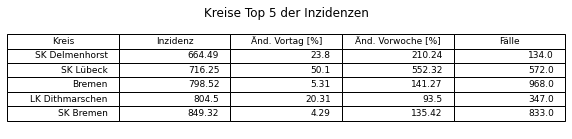

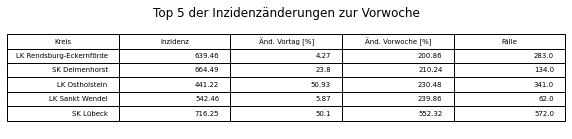

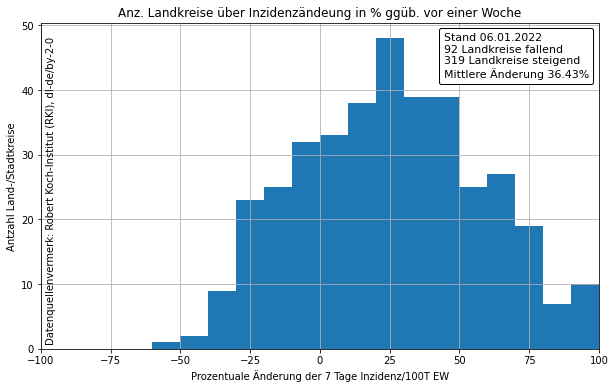

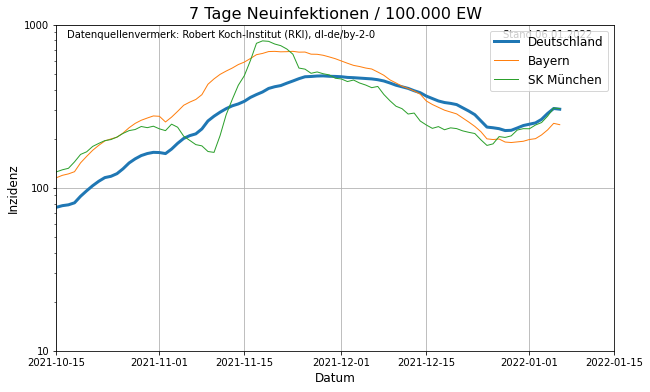

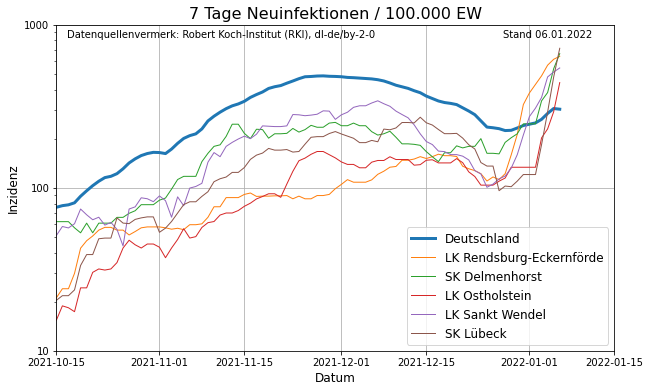

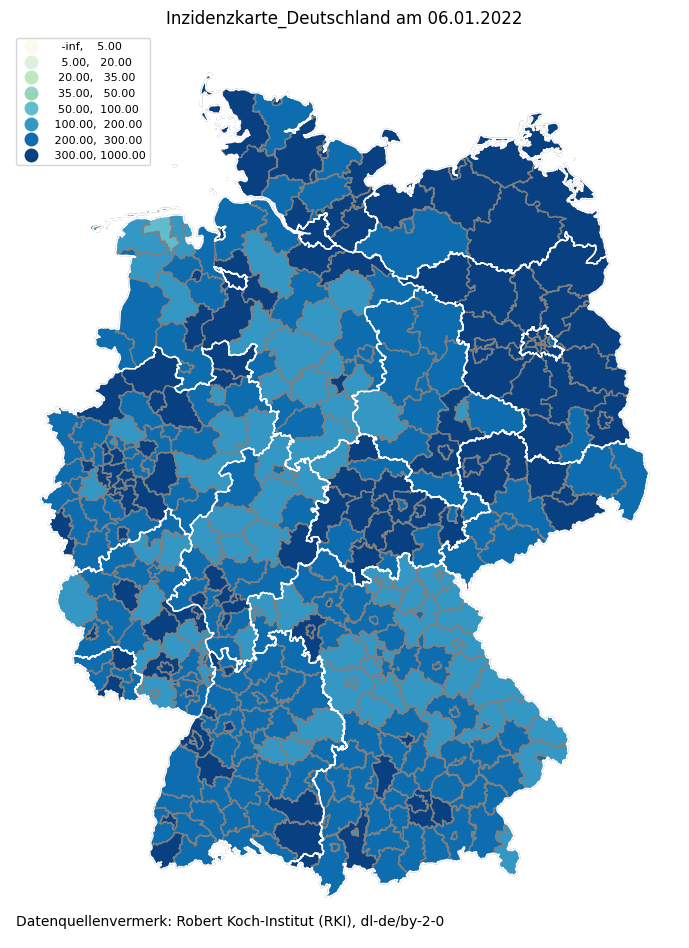

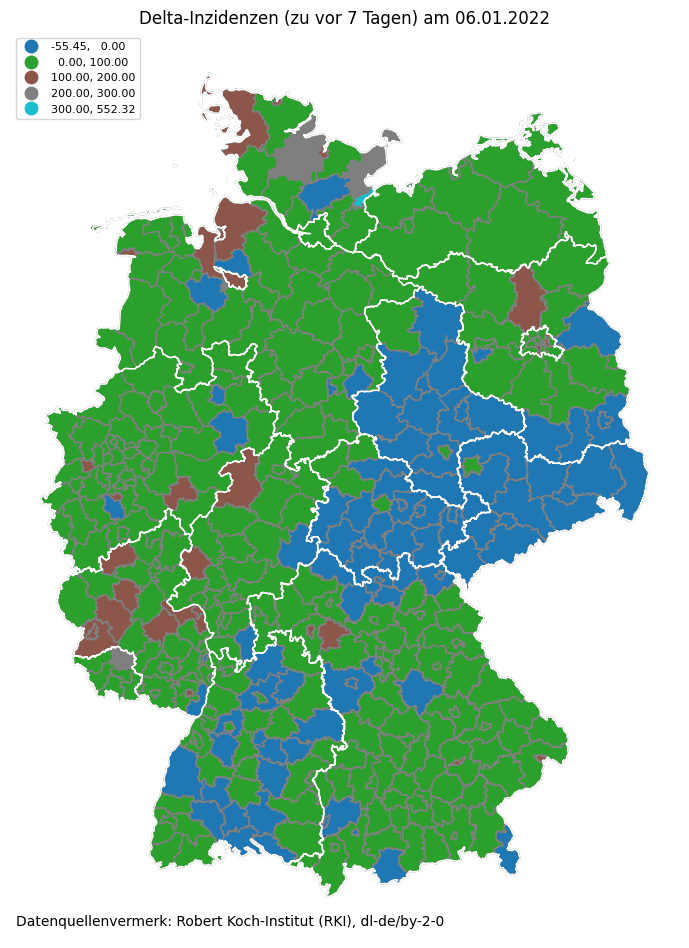

In [4]:
# Load the covid database via pd.read_csv()

covid  = read_covid_database(covid_file)
bland  = get_bundeslad_geodata(bula_file)
kreise = get_kreise_geodata(kreise_file)
einwohner = extract_einwohnerzahlen(kreise)

start=covid['Meldedatum'].min()
ende=covid['Meldedatum'].max()

check_panbegin = (start == pan_begin)

landkreise=covid['Landkreis'].unique()
bundeslaender=covid['Bundesland'].unique()
check_meta = (len(landkreise), len(bundeslaender), einwohner['Deutschland']) == metadata

result = get_tagesinzidenzen(covid, start, ende)

missing_lk = result.iloc[-1].isna().sum()


# Now we do some calculations with our daily incidence dataframe

# Calculate Rolling 7 day average and 7 day accumulation    
    
result.fillna(value=0, inplace=True)
result_m7 = result.rolling(7).mean()
result_s7 = result.rolling(7).sum()

# Calculate 7 day Inzidenz per 100.000 inhabitants:

for i in result_s7.columns:
    result_s7[i] = result_s7[i]*100000/ float(einwohner.loc[i])

# Zeitliche Änderung der Inzidenzen berechnen:

dinz_dt = pd.DataFrame(
    {'INZ': result_s7.iloc[-1], 
     'DINZ1': (result_s7.iloc[-1] - result_s7.iloc[-2])/result_s7.iloc[-2]*100,
     'DINZ7': (result_s7.iloc[-1] - result_s7.iloc[-8])/result_s7.iloc[-8]*100, 
    'MELD': result.iloc[-1]}
)


# Finally a copy of kreise including  Inzidenzen and Delta-Inzidenzen 
# for plotting the colored geoplots

tmpkreise = kreise.copy()
tmpdinzdt=dinz_dt.reset_index()

tmpdinzdt.rename(columns={'index':'county'}, inplace=True)
tmpkreise=pd.merge(tmpkreise, tmpdinzdt, on='county', how='left')



if DEBUG:
    if check_panbegin:
        print('Startdatum in covid DB ist ok.')
    else:
        print('Unplausibilität in Startdatum der Pandemie in den covid Daten')
    if check_meta:
        print('Landkreis-, Bundesland- und Einwohnerzahl sind ok!')
    else:
        print('Unplausibilität in Landkreis-, Bundesland- oder Einwohnerzahl!')
    print('Start Erfassung:', start.strftime('%d.%m.%Y')) 
    print('Ende  Erfassung:', ende.strftime('%d.%m.%Y'))
    print('Einwohner Deutschland:', einwohner['Deutschland'])
    print('Anzahl Bundesländer:', len(bundeslaender))
    print('Anzahl Landkreise:', len(landkreise))
    print('Anzahl nicht meldender Landkreise:', missing_lk)

inz_overview(overview)
create_pdf_report()

In [ ]:
# End of main code

In [ ]:
#
# Appendix: Example commands to plot figures and tables
#

In [ ]:
#
# Print table with the top 5 Landkreise with the highest change in Inzidenz
#
top5_inzidenzaenderungen = dinz_dt.sort_values(by='DINZ7').iloc[-5:]
fig=print_tabular_overview(top5_inzidenzaenderungen)

In [ ]:
#
# Just plot some Landkreise or bundeslaender 
# compared to Germany as reference
#
ref=['Deutschland']
sample = ['Bayern', 'SK München']
fig=inzidenz_lineplot(ref,sample,filename='inzplot_Bayern')

In [ ]:
#
# Plot the top 5 Landkreise with the highest change in Inzidenz
# compared to Germany as reference
#
ref=['Deutschland']
top5_dinz_dt7 = dinz_dt.sort_values(by='DINZ7').iloc[-5:]
top5_kreise_delta_inz7 = top5_dinz_dt7.index
fig=inzidenz_lineplot(ref,top5_kreise_delta_inz7,filename='inzplot_top5')

In [ ]:
# Geoplot of all Landkreise and Inzidenz of last available day
fig = geoplot(tmpkreise, color='INZ', cmap='GnBu', 
              bins=[5, 20, 35, 50, 100, 200, 300, 1000],
              filename='Inzidenzkarte')

In [ ]:
# Geoplot of all Landkreise showing the change of Inzidenz compared to 7 days before
fig = geoplot(tmpkreise, color='DINZ7', cmap='tab10', 
              bins=[0, 100, 200, 300], title='Delta-Inzidenzen (zu vor 7 Tagen)',
              filename='Delta-Inzidenz')

In [ ]:
# Histogram showing number of landkreise over Inzidenz change compared to day before last
# available data
fig = didt_hist(dinz_dt.DINZ1.iloc[0:411],ref=' ggüb. vor einem Tag', file='Histogramm1')

In [ ]:
# Histogram showing number of landkreise over Inzidenz change compared to week before
#
fig = didt_hist(dinz_dt.DINZ7.iloc[0:411],ref=' ggüb. vor einer Woche', file='Histogramm7')

In [ ]:
### Debug and test section

In [ ]:
#
# Just some lines to test and look into variables
#